In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:7


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 23

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 2081)
GT S-parameters shape:  (3, 2, 2081)
Y S-parameters shape:  (3, 2, 155)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (2081,)
Y frequencies shape:  (155,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  40000000.0
Mean frequency spacing:  19211538.46153846
STD frequency spacing:  6057692.307692306
Mode frequency spacing:  18000000.0
Number of samples with non-equal spacing:  81


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  2081
N_SPARAMS:  3


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 2081])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 2081])


## Plot some stuff

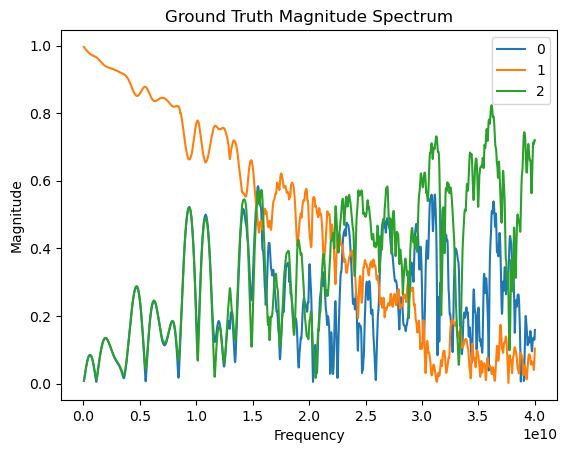

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

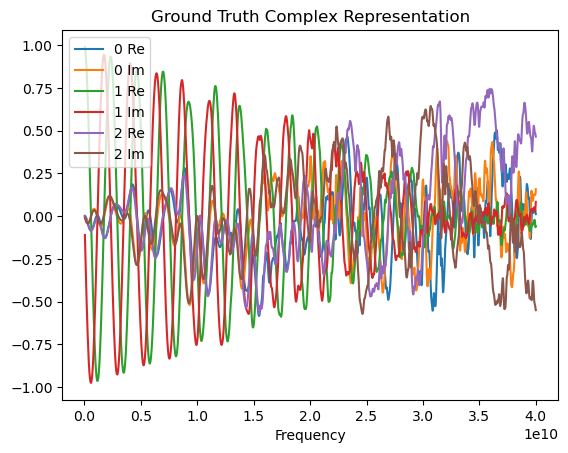

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 2

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)

Number of Ground Truth Frequency Points:  2081
Number of Measurements:  2
Undersampling Ratio:  0.0009610764055742432
[   0 2080]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 2])
y_freqs shape:  (2,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  8
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 2081])


/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  30098


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = 153

LR = 2e-4
NUM_ITER = 2000
TOTAL_ITERS = NUM_ITER * (NUM_ACTIVE + 1)
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(x.shape)
        print(outputs.shape)
        abs_differences = torch.square(torch.subtract(x[0], outputs))

        # Sum to go to [1000]
        abs_differences = torch.mean(abs_differences, dim=0)
        print(abs_differences)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(abs_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(abs_differences, len(abs_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  2.0581884384155273
NOISE LEVEL:  0.9999775724746209

ITER  999
TIME:  30.76595640182495
NOISE LEVEL:  0.9778218559886167

ITER  1999
TIME:  60.23004484176636
NOISE LEVEL:  0.9561355820490228

NUM_SAMPLES  0
TIME:  60.23004484176636
torch.Size([1, 6, 2081])
torch.Size([6, 2081])
tensor([0.1601, 0.1598, 0.1600,  ..., 0.0929, 0.0927, 0.0907], device='cuda:7')
[   0 2023 2080]
ITER  0
TIME:  60.264829874038696
NOISE LEVEL:  0.9561141382939906

ITER  999
TIME:  89.50055074691772
NOISE LEVEL:  0.9349302694159288

ITER  1999
TIME:  119.05787181854248
NOISE LEVEL:  0.9141952512602215

NUM_SAMPLES  1
TIME:  119.05787181854248
torch.Size([1, 6, 2081])
torch.Size([6, 2081])
tensor([0.1492, 0.1493, 0.1504,  ..., 0.0886, 0.0901, 0.0918], device='cuda:7')
[   0  453 2023 2080]
ITER  0
TIME:  119.0931453704834
NOISE LEVEL:  0.9141747481230225

ITER  999
TIME:  148.51396226882935
NOISE LEVEL:  0.8939200973232492

ITER  1999
TIME:  178.2725625038147
NOISE LEVEL:  0.8740946086701443

NUM_

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([5, 6, 2081])
torch.Size([6, 2081])
torch.Size([6, 2081])


## Plot metrics and outputs

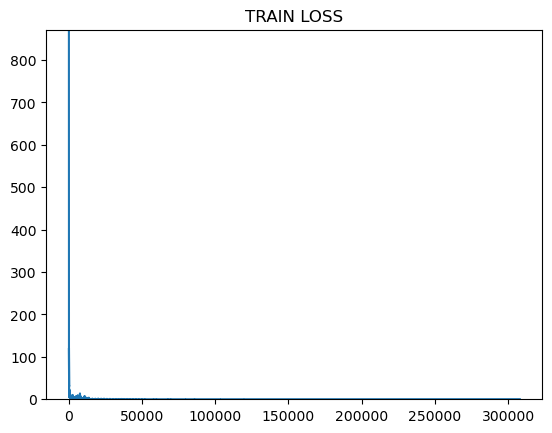

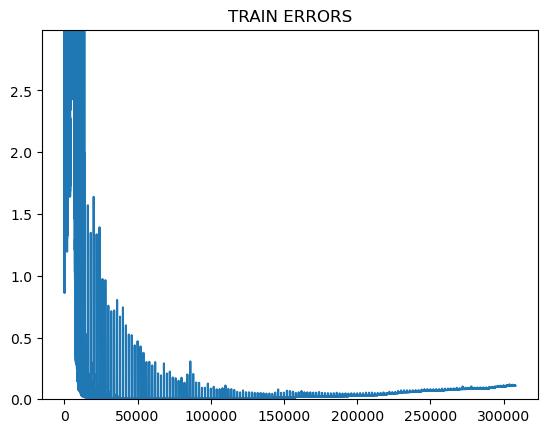

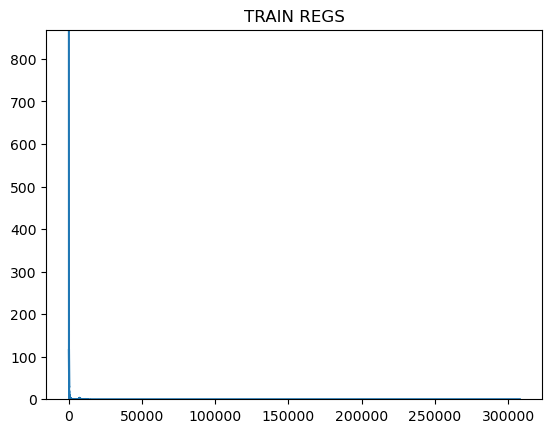

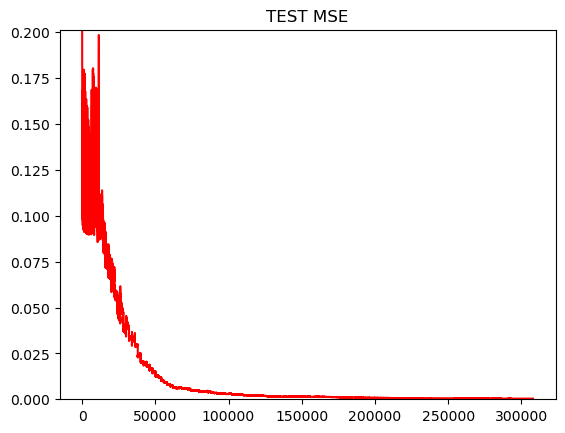

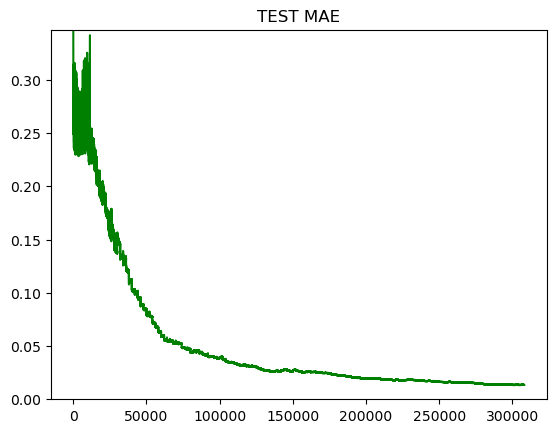

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.00035755604039877653
Best Test MSE:  0.00035063832183368504
Best Test MSE Iteration:  304026


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case23/case23.s2p
[4.0000e+07 4.3600e+08 7.8250e+08 1.2280e+09 1.6735e+09 2.0200e+09
 2.3170e+09 2.8120e+09 3.1090e+09 3.3565e+09 3.6040e+09 3.8020e+09
 3.9505e+09 4.0000e+09 4.0360e+09 4.0720e+09 4.1440e+09 4.2340e+09
 4.3420e+09 4.4500e+09 4.5580e+09 4.6660e+09 4.7740e+09 4.8820e+09
 4.9900e+09 5.1880e+09 5.4220e+09 5.6380e+09 5.8360e+09 6.0520e+09
 6.2680e+09 6.5020e+09 6.7540e+09 7.0420e+09 7.3480e+09 7.6720e+09
 7.8700e+09 8.0680e+09 8.2840e+09 8.5000e+09 8.7340e+09 8.9860e+09
 9.2380e+09 9.4720e+09 9.8140e+09 1.0210e+10 1.0714e+10 1.0768e+10
 1.1038e+10 1.1326e+10 1.1614e+10 1.1884e+10 1.2442e+10 1.2892e+10
 1.3324e+10 1.3630e+10 1.3954e+10 1.4368e+10 1.4818e+10 1.5376e+10
 1.5628e+10 1.5916e+10 1.6294e+10 1.6582e+10 1.6852e+10 1.7374e+10
 1.7608e+10 1.7878e+10 1.8256e+10 1.8670e+10 1.9030e+10 1.9300e+10
 1.9894e+10 2.0236e+10 2.0668e+10 2.0974e+10 2.1190e+10 2.1640e+10
 2.1892e+10 2.2000e+10 2.2234e+10 2.2396e+10 2.2792e+10 2.2990e+1

/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 1.825138846412301 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.14357160031795502 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 was not subtantially better than 2 (err 1.7561742175107344 vs 1.734553215747785)
Performing fit with 3 poles.
  Fitting took 0.1630888395011425 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.9927732744145683 vs 1.734553215747785)
Performing fit with 4 poles.
  Fitting took 0.1767996195703745 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 2 (err 1.2112638741344186 vs 1.734553215747785)
Performing fit with 5 poles.
  Fitting took 0.20870602689683437 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 was not 

In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([2081, 2, 2, 2])
torch.Size([2081, 2, 2, 2])
torch.Size([155, 2, 2, 2])
(2081, 2, 2, 2)
(2081, 2, 2, 2)
(3, 2, 2081)
(3, 2, 2081)
float32
float32
DIP PSNR:       40.48715895914961
VF PSNR:        29.438852125242015
Final DIP MSE:  0.00035755604039877653
VF MSE:         0.004551711957901716
Mean DIP MSE:  0.0003559519536793232


(2081,)
torch.Size([6, 2081])
torch.Size([1, 6, 2081])
torch.Size([1, 6, 155])
torch.Size([1, 6, 2081])
torch.Size([1, 6, 2081])


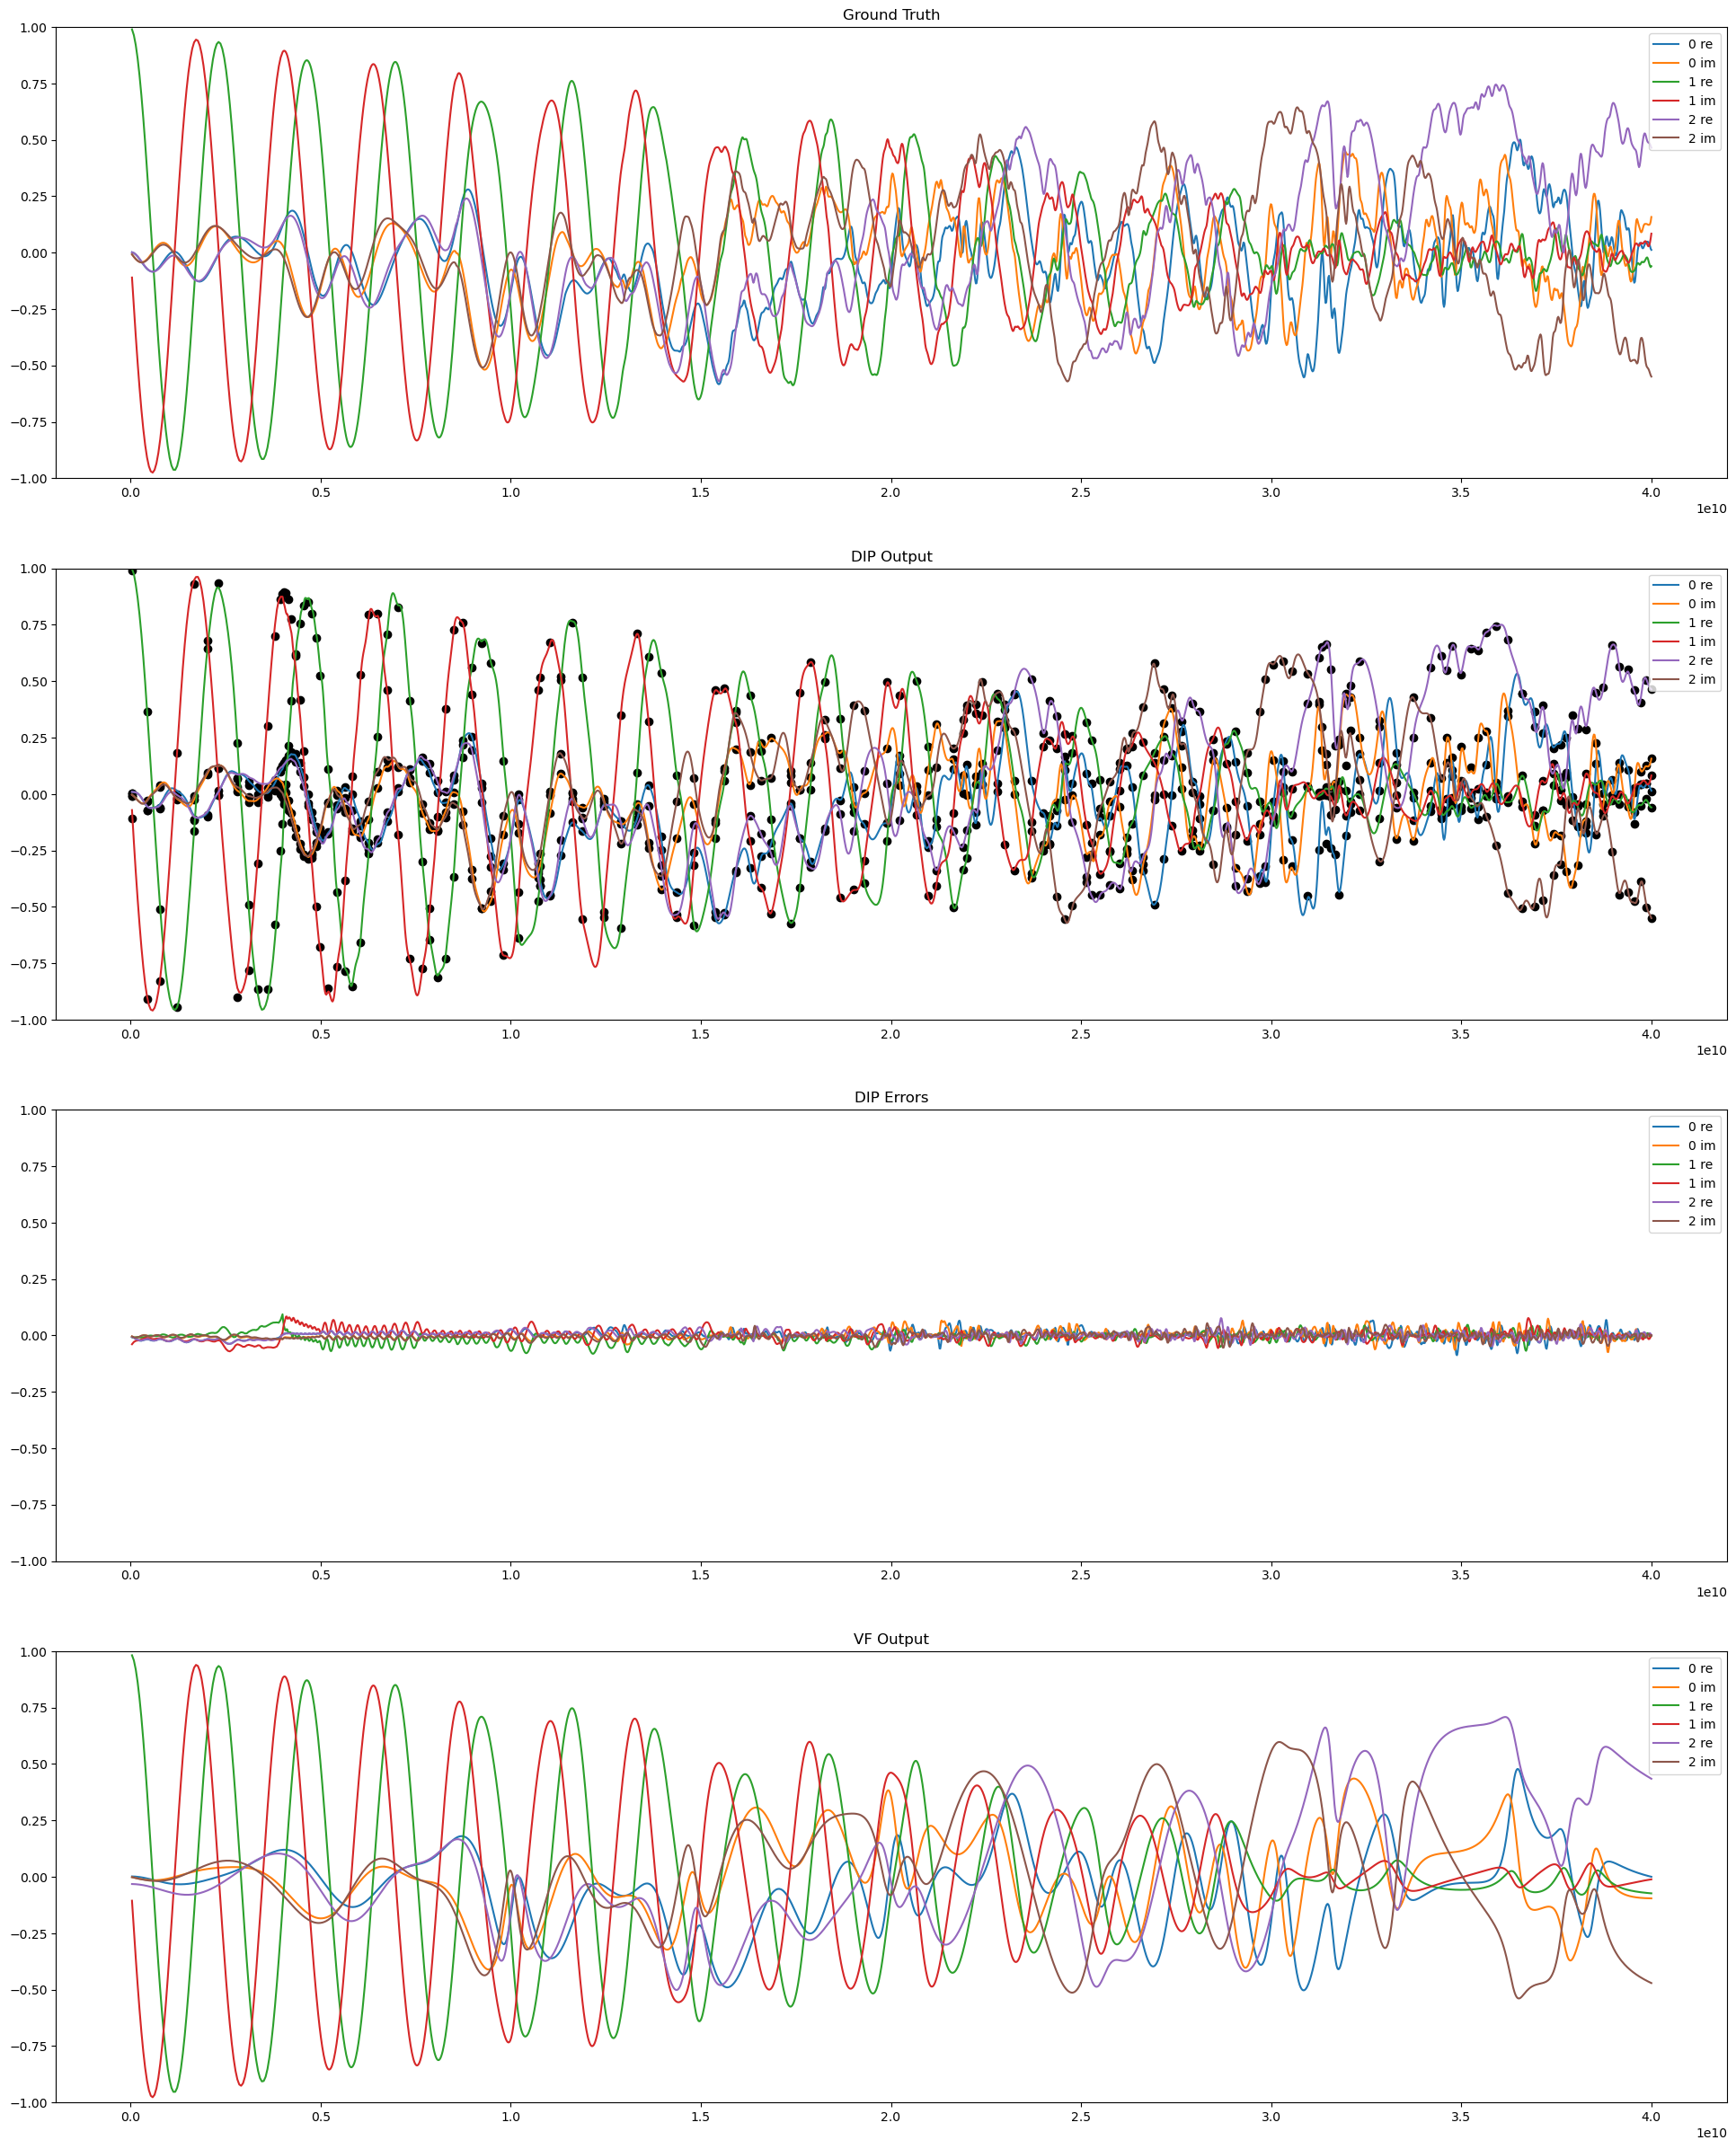

In [33]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.1685e-04, 1.1791e-04, 1.2586e-04, 1.4446e-04, 1.7101e-04, 2.0414e-04,
         2.4803e-04, 2.6712e-04, 2.5953e-04, 2.3998e-04, 2.1051e-04, 1.9368e-04,
         1.8675e-04, 1.8240e-04, 1.7875e-04, 1.8254e-04, 1.9696e-04, 2.1645e-04,
         2.4233e-04, 2.6481e-04, 2.8357e-04, 2.9369e-04, 2.9317e-04, 2.9345e-04,
         2.9275e-04, 2.7928e-04, 2.5239e-04, 2.2139e-04, 1.8675e-04, 1.6316e-04,
         1.5350e-04, 1.5673e-04, 1.7426e-04, 2.0154e-04, 2.4253e-04, 2.8025e-04,
         3.1283e-04, 3.2921e-04, 3.2846e-04, 3.3426e-04, 3.4598e-04, 3.3784e-04,
         3.1178e-04, 3.6724e-04, 3.2909e-04, 2.9803e-04, 2.1693e-04, 2.2233e-04,
         2.4670e-04, 2.6607e-04, 2.7582e-04, 2.8218e-04, 2.8810e-04, 3.0119e-04,
         3.2221e-04, 3.2519e-04, 3.0823e-04, 2.9836e-04, 2.9423e-04, 2.9248e-04,
         2.9255e-04, 2.9630e-04, 3.0207e-04, 3.0155e-04, 2.9525e-04, 2.8207e-04,
         2.6185e-04, 2.4571e-04, 2.3340e-04, 2.2201e-04, 2.1395e-04, 2.0956e-04,
         2.0996e-04, 2.0726e

In [30]:
print(dip_errors[-1])

tensor([[-7.7352e-03, -1.0554e-02, -1.5977e-02, -2.0428e-02, -2.3151e-02,
         -2.3626e-02, -2.0965e-02, -1.9023e-02, -1.7004e-02, -1.8006e-02,
         -2.1533e-02, -2.3218e-02, -2.2986e-02, -2.0737e-02, -1.6831e-02,
         -1.5573e-02, -1.7667e-02, -2.0375e-02, -2.4563e-02, -2.6373e-02,
         -2.6599e-02, -2.4458e-02, -2.0462e-02, -1.6894e-02, -1.3840e-02,
         -1.5123e-02, -2.0383e-02, -2.5434e-02, -2.9574e-02, -3.1121e-02,
         -2.9224e-02, -2.5707e-02, -1.9776e-02, -1.7660e-02, -1.8800e-02,
         -2.0932e-02, -2.3825e-02, -2.4252e-02, -2.2326e-02, -1.9692e-02,
         -1.6743e-02, -1.6342e-02, -1.9049e-02, -1.9732e-02, -1.9643e-02,
         -1.6415e-02, -1.2542e-02, -1.5129e-02, -2.0606e-02, -2.6490e-02,
         -3.2950e-02, -3.6565e-02, -3.7360e-02, -3.5061e-02, -2.9602e-02,
         -2.4387e-02, -1.9319e-02, -1.8488e-02, -2.1796e-02, -2.3578e-02,
         -2.3720e-02, -2.2088e-02, -1.8510e-02, -1.7865e-02, -1.9877e-02,
         -2.0096e-02, -1.8123e-02, -1.

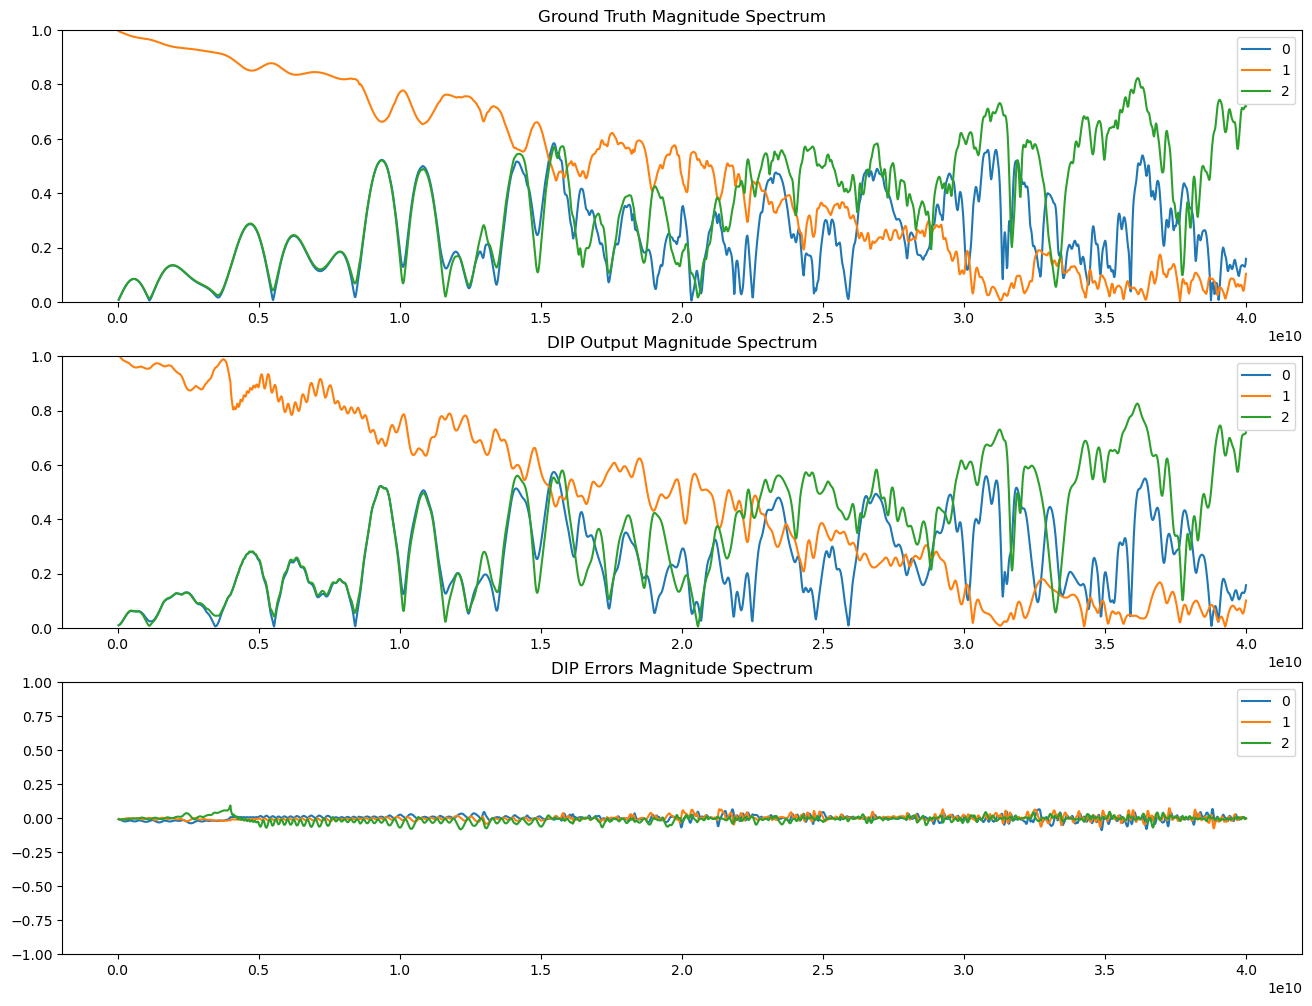

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[   0    8   15   24   33   40   46   56   62   67   72   76   79   80
   82   84   88   93   99  105  111  117  123  129  135  146  159  171
  182  194  206  219  233  249  266  284  295  306  318  330  343  357
  371  384  403  425  453  456  471  487  503  518  549  574  598  615
  633  656  681  712  726  742  763  779  794  823  836  851  872  895
  915  930  963  982 1006 1023 1035 1060 1074 1080 1093 1102 1124 1135
 1149 1174 1191 1201 1211 1223 1234 1255 1262 1274 1289 1303 1314 1321
 1337 1354 1368 1379 1393 1410 1420 1440 1459 1472 1489 1508 1516 1528
 1542 1555 1578 1594 1599 1605 1612 1618 1624 1634 1640 1654 1683 1708
 1732 1757 1773 1781 1789 1802 1817 1827 1839 1853 1870 1891 1909 1922
 1937 1948 1956 1965 1972 1984 1999 2010 2023 2033 2046 2055 2064 2073
 2080]
